In [7]:
import os
print("Current folder:", os.getcwd())


Current folder: /Users/tariqalsaleh/PycharmProjects/CarbonIntensityProject/notebooks


In [8]:
import os
import requests
import pandas as pd

def fetch_carbon_intensity_range(start_utc: str, end_utc: str, chunk_days: int = 7) -> pd.DataFrame:

    start = pd.to_datetime(start_utc, utc=True)
    end = pd.to_datetime(end_utc, utc=True)

    all_rows = []
    cur = start

    while cur < end:
        nxt = min(cur + pd.Timedelta(days=chunk_days), end)
        url = f"https://api.carbonintensity.org.uk/intensity/{cur:%Y-%m-%dT%H:%MZ}/{nxt:%Y-%m-%dT%H:%MZ}"
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        data = r.json()["data"]

        for rec in data:
            all_rows.append({
                "from": rec["from"],
                "to": rec["to"],
                "forecast": rec["intensity"]["forecast"],
                "actual": rec["intensity"]["actual"],
                "index": rec["intensity"]["index"],
            })

        print(f"Fetched: {cur:%Y-%m-%d} → {nxt:%Y-%m-%d} | rows so far: {len(all_rows)}")
        cur = nxt

    df = pd.DataFrame(all_rows)
    df["from"] = pd.to_datetime(df["from"], utc=True)
    df["to"] = pd.to_datetime(df["to"], utc=True)

    # Use 'from' as the time index (start of each half-hour block)
    df = df.sort_values("from").set_index("from")

    return df

# ===== Choosing big date range here =====
api_big_df = fetch_carbon_intensity_range(
    start_utc="2023-01-01T00:00Z",
    end_utc="2024-12-31T23:00Z",
    chunk_days=7
)

print("Final shape:", api_big_df.shape)
display(api_big_df.head())
display(api_big_df.tail())

# ===== Save to data to reuse it =====
os.makedirs("data", exist_ok=True)
out_path = os.path.join("data", "gb_carbonintensity_api_2023_2024.csv")
api_big_df.to_csv(out_path)
print("Saved to:", out_path)

Fetched: 2023-01-01 → 2023-01-08 | rows so far: 337
Fetched: 2023-01-08 → 2023-01-15 | rows so far: 674
Fetched: 2023-01-15 → 2023-01-22 | rows so far: 1011
Fetched: 2023-01-22 → 2023-01-29 | rows so far: 1348
Fetched: 2023-01-29 → 2023-02-05 | rows so far: 1685
Fetched: 2023-02-05 → 2023-02-12 | rows so far: 2022
Fetched: 2023-02-12 → 2023-02-19 | rows so far: 2359
Fetched: 2023-02-19 → 2023-02-26 | rows so far: 2696
Fetched: 2023-02-26 → 2023-03-05 | rows so far: 3033
Fetched: 2023-03-05 → 2023-03-12 | rows so far: 3370
Fetched: 2023-03-12 → 2023-03-19 | rows so far: 3707
Fetched: 2023-03-19 → 2023-03-26 | rows so far: 4044
Fetched: 2023-03-26 → 2023-04-02 | rows so far: 4381
Fetched: 2023-04-02 → 2023-04-09 | rows so far: 4718
Fetched: 2023-04-09 → 2023-04-16 | rows so far: 5055
Fetched: 2023-04-16 → 2023-04-23 | rows so far: 5392
Fetched: 2023-04-23 → 2023-04-30 | rows so far: 5729
Fetched: 2023-04-30 → 2023-05-07 | rows so far: 6066
Fetched: 2023-05-07 → 2023-05-14 | rows so far: 

,to,forecast,actual,index
from,,,,
2022-12-31 23:30:00+00:00,2023-01-01 00:00:00+00:00,75,65.0,low
2023-01-01 00:00:00+00:00,2023-01-01 00:30:00+00:00,73,72.0,low
2023-01-01 00:30:00+00:00,2023-01-01 01:00:00+00:00,63,80.0,low
2023-01-01 01:00:00+00:00,2023-01-01 01:30:00+00:00,71,72.0,low
2023-01-01 01:30:00+00:00,2023-01-01 02:00:00+00:00,76,65.0,low


,to,forecast,actual,index
from,,,,
2024-12-31 20:30:00+00:00,2024-12-31 21:00:00+00:00,57,55.0,low
2024-12-31 21:00:00+00:00,2024-12-31 21:30:00+00:00,54,52.0,low
2024-12-31 21:30:00+00:00,2024-12-31 22:00:00+00:00,49,53.0,low
2024-12-31 22:00:00+00:00,2024-12-31 22:30:00+00:00,48,52.0,low
2024-12-31 22:30:00+00:00,2024-12-31 23:00:00+00:00,45,54.0,low


Saved to: data/gb_carbonintensity_api_2023_2024.csv


In [9]:
import pandas as pd

df_api = pd.read_csv(
    "data/gb_carbonintensity_api_2023_2024.csv",
    parse_dates=["from", "to"]
)

print(df_api.shape)
df_api.head()

(35068, 5)


,from,to,forecast,actual,index
0,2022-12-31 23:30:00+00:00,2023-01-01 00:00:00+00:00,75,65.0,low
1,2023-01-01 00:00:00+00:00,2023-01-01 00:30:00+00:00,73,72.0,low
2,2023-01-01 00:30:00+00:00,2023-01-01 01:00:00+00:00,63,80.0,low
3,2023-01-01 01:00:00+00:00,2023-01-01 01:30:00+00:00,71,72.0,low
4,2023-01-01 01:30:00+00:00,2023-01-01 02:00:00+00:00,76,65.0,low


In [10]:
df_api = df_api.set_index("from").sort_index()

df_api.head()

,to,forecast,actual,index
from,,,,
2022-12-31 23:30:00+00:00,2023-01-01 00:00:00+00:00,75,65.0,low
2023-01-01 00:00:00+00:00,2023-01-01 00:30:00+00:00,73,72.0,low
2023-01-01 00:30:00+00:00,2023-01-01 01:00:00+00:00,63,80.0,low
2023-01-01 01:00:00+00:00,2023-01-01 01:30:00+00:00,71,72.0,low
2023-01-01 01:30:00+00:00,2023-01-01 02:00:00+00:00,76,65.0,low


In [11]:
# Keeping only the target I want to model
df_api2 = df_api[["actual"]].copy()

# Make sure it's numeric (sometimes it loads as text)
df_api2["actual"] = pd.to_numeric(df_api2["actual"], errors="coerce")

# Drop any missing rows created by conversion
df_api2 = df_api2.dropna()

df_api2.head()

,actual
from,
2022-12-31 23:30:00+00:00,65.0
2023-01-01 00:00:00+00:00,72.0
2023-01-01 00:30:00+00:00,80.0
2023-01-01 01:00:00+00:00,72.0
2023-01-01 01:30:00+00:00,65.0


In [12]:
df_hourly = df_api2.resample("1h").mean()

print(df_hourly.shape)
df_hourly.head()

(17544, 1)


,actual
from,
2022-12-31 23:00:00+00:00,65.0
2023-01-01 00:00:00+00:00,76.0
2023-01-01 01:00:00+00:00,68.5
2023-01-01 02:00:00+00:00,65.0
2023-01-01 03:00:00+00:00,67.5


In [13]:
df_ml = df_hourly.rename(columns={"actual": "carbon_intensity"}).copy()
df_ml.head()

,carbon_intensity
from,
2022-12-31 23:00:00+00:00,65.0
2023-01-01 00:00:00+00:00,76.0
2023-01-01 01:00:00+00:00,68.5
2023-01-01 02:00:00+00:00,65.0
2023-01-01 03:00:00+00:00,67.5


In [14]:
# df_hourly: has datetime index and a single column 'carbon_intensity'
df_ml = df_hourly.rename(columns={"actual": "carbon_intensity"}).copy()  # if yours is still called 'actual'

# Target = next hour value (t+1)
df_ml["target_next_hour"] = df_ml["carbon_intensity"].shift(-1)

df_ml[["carbon_intensity", "target_next_hour"]].head()

,carbon_intensity,target_next_hour
from,,
2022-12-31 23:00:00+00:00,65.0,76.0
2023-01-01 00:00:00+00:00,76.0,68.5
2023-01-01 01:00:00+00:00,68.5,65.0
2023-01-01 02:00:00+00:00,65.0,67.5
2023-01-01 03:00:00+00:00,67.5,72.0


In [15]:
for lag in range(1, 25):  # 1..24
    df_ml[f"lag_{lag}"] = df_ml["carbon_intensity"].shift(lag)

In [16]:
df_ml = df_ml.dropna()

print("Final ML table shape:", df_ml.shape)
df_ml.head()

Final ML table shape: (17382, 26)


,carbon_intensity,target_next_hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
from,,,,,,,,,,,,,,,,,,,,,
2023-01-01 23:00:00+00:00,152.5,140.5,151.5,159.0,163.0,162.0,159.0,161.0,152.5,137.0,...,77.5,74.5,72.5,72.5,72.0,67.5,65.0,68.5,76.0,65.0
2023-01-02 00:00:00+00:00,140.5,128.0,152.5,151.5,159.0,163.0,162.0,159.0,161.0,152.5,...,78.0,77.5,74.5,72.5,72.5,72.0,67.5,65.0,68.5,76.0
2023-01-02 01:00:00+00:00,128.0,124.5,140.5,152.5,151.5,159.0,163.0,162.0,159.0,161.0,...,85.0,78.0,77.5,74.5,72.5,72.5,72.0,67.5,65.0,68.5
2023-01-02 02:00:00+00:00,124.5,120.0,128.0,140.5,152.5,151.5,159.0,163.0,162.0,159.0,...,89.5,85.0,78.0,77.5,74.5,72.5,72.5,72.0,67.5,65.0
2023-01-02 03:00:00+00:00,120.0,124.0,124.5,128.0,140.5,152.5,151.5,159.0,163.0,162.0,...,91.5,89.5,85.0,78.0,77.5,74.5,72.5,72.5,72.0,67.5


In [17]:
train = df_ml.loc["2024-01-01":"2024-10-31"]
test  = df_ml.loc["2024-11-01":"2024-12-31"]

feature_cols = [f"lag_{i}" for i in range(1, 25)]
X_train = train[feature_cols].values
y_train = train["target_next_hour"].values

X_test  = test[feature_cols].values
y_test  = test["target_next_hour"].values

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (7280, 24) (7280,)
Test : (1462, 24) (1462,)


In [18]:
ts = test.index[0]
print("Test row timestamp (t):", ts)
print("Last hour used (lag_1 = t-1):", test.loc[ts, "lag_1"])
print("Target (next hour y = t+1):", test.loc[ts, "target_next_hour"])

print("Actual at t+1 from series:", df_hourly.loc[ts + pd.Timedelta(hours=1), "actual"])

Test row timestamp (t): 2024-11-01 00:00:00+00:00
Last hour used (lag_1 = t-1): 129.5
Target (next hour y = t+1): 122.5
Actual at t+1 from series: 122.5


In [19]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [20]:
import numpy as np

mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred)**2))

print(f"Ridge → MAE: {mae:.2f} gCO2/kWh")
print(f"Ridge → RMSE: {rmse:.2f} gCO2/kWh")

Ridge → MAE: 10.59 gCO2/kWh
Ridge → RMSE: 14.55 gCO2/kWh


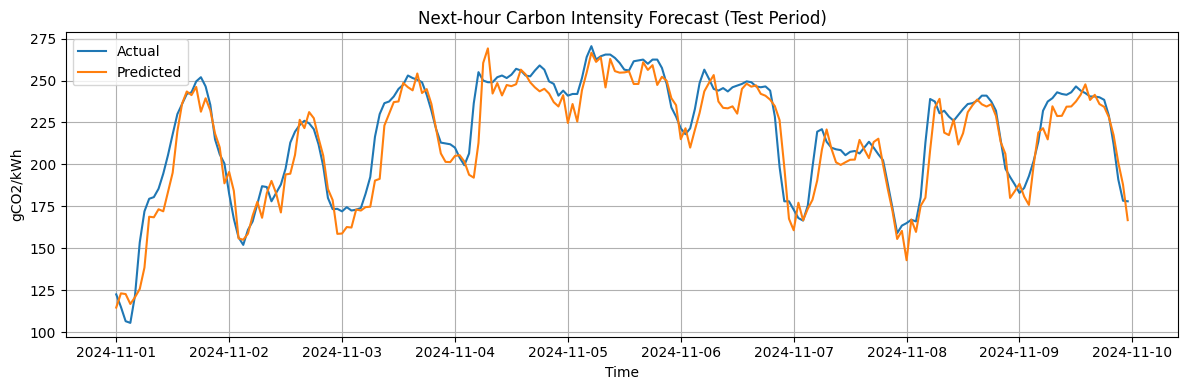

In [21]:
import matplotlib.pyplot as plt

hours = 24 * 9  # 9 days

plt.figure(figsize=(12,4))
plt.plot(test.index[:hours], y_test[:hours], label="Actual")
plt.plot(test.index[:hours], y_pred[:hours], label="Predicted")
plt.title("Next-hour Carbon Intensity Forecast (Test Period)")
plt.ylabel("gCO2/kWh")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
y_persist = X_test[:, 0]  # lag_1

mae_persist = np.mean(np.abs(y_test - y_persist))
rmse_persist = np.sqrt(np.mean((y_test - y_persist)**2))

print(f"Persistence → MAE: {mae_persist:.2f}, RMSE: {rmse_persist:.2f}")

Persistence → MAE: 14.06, RMSE: 20.65


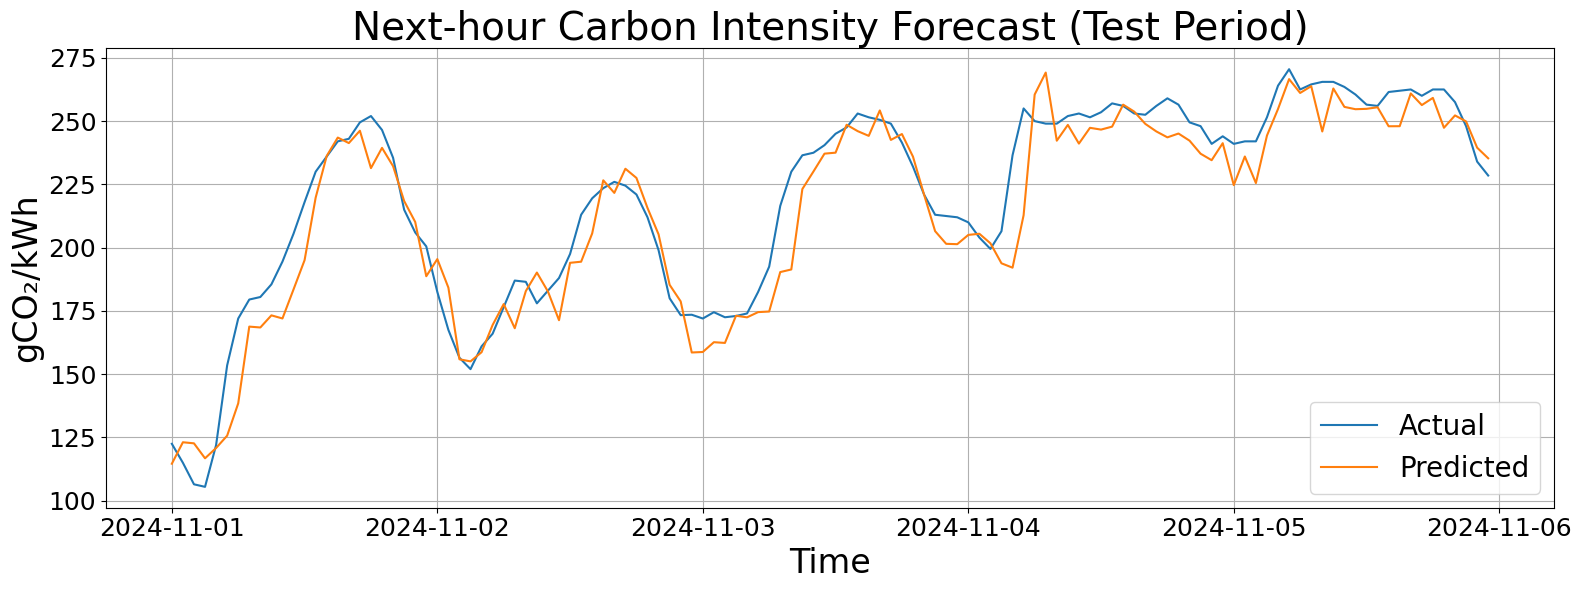

In [23]:
import matplotlib.pyplot as plt

hours = 24 * 5  # show 5 days (cleaner than 9)
t = test.index[:hours]

plt.figure(figsize=(16,6))
plt.plot(t, y_test[:hours], label="Actual")
plt.plot(t, y_pred[:hours], label="Predicted")

plt.title("Next-hour Carbon Intensity Forecast (Test Period)", fontsize=28)
plt.ylabel("gCO₂/kWh", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.legend(fontsize=20)
plt.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

plt.savefig("fig_next_hour_forecast.pdf", bbox_inches="tight")
plt.savefig("fig_next_hour_forecast.png", dpi=300, bbox_inches="tight")
plt.show()


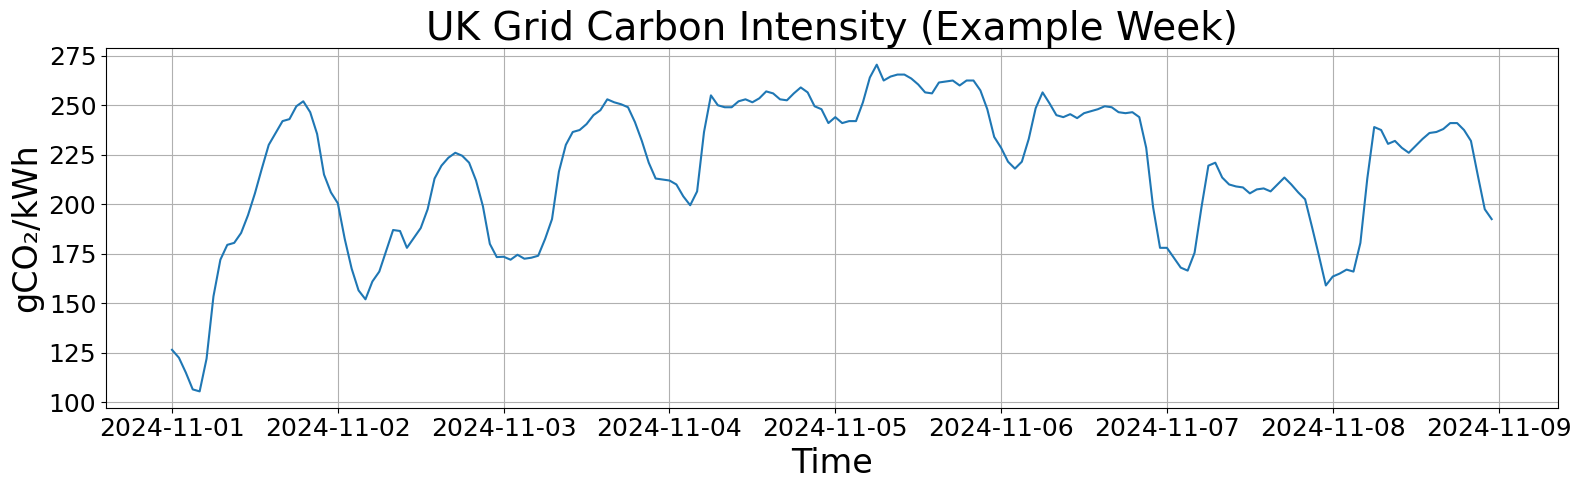

In [24]:
week = df_hourly.loc["2024-11-01":"2024-11-08"]  # 1 week

plt.figure(figsize=(16,5))
plt.plot(week.index, week["actual"], label="Carbon intensity")
plt.title("UK Grid Carbon Intensity (Example Week)", fontsize=28)
plt.ylabel("gCO₂/kWh", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

plt.savefig("fig_data_overview_week.pdf", bbox_inches="tight")
plt.savefig("fig_data_overview_week.png", dpi=300, bbox_inches="tight")
plt.show()


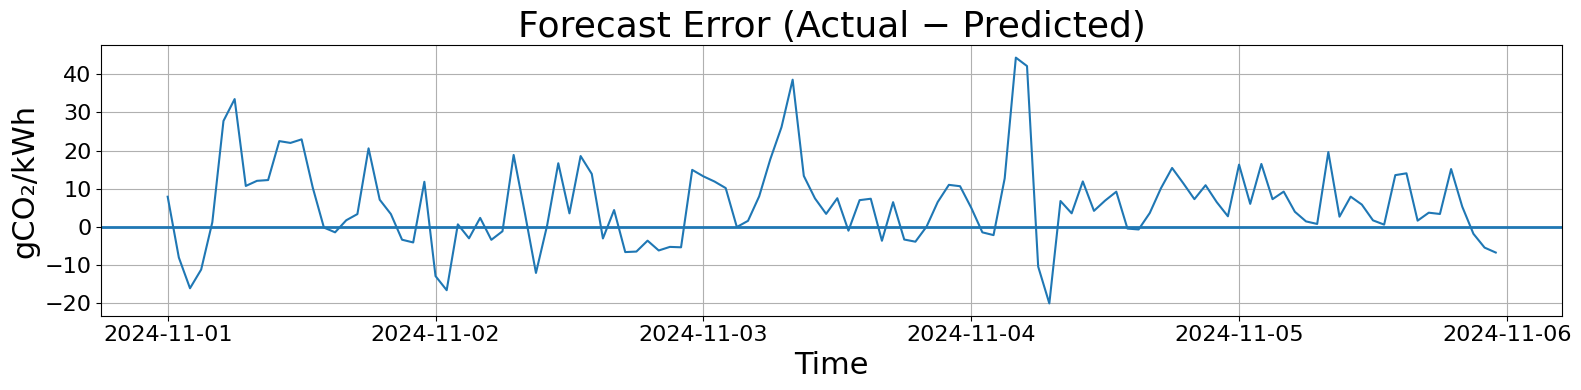

In [25]:
err = y_test[:hours] - y_pred[:hours]

plt.figure(figsize=(16,4))
plt.plot(t, err)
plt.axhline(0, linewidth=2)
plt.title("Forecast Error (Actual − Predicted)", fontsize=26)
plt.ylabel("gCO₂/kWh", fontsize=22)
plt.xlabel("Time", fontsize=22)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig("fig_forecast_error.pdf", bbox_inches="tight")
plt.savefig("fig_forecast_error.png", dpi=300, bbox_inches="tight")
plt.show()


In [26]:
import pandas as pd

results_table = pd.DataFrame({
    "Model": ["Persistence (baseline)", "Ridge (lags 1–24)"],
    "MAE (gCO₂/kWh)": [mae_persist, mae],
    "RMSE (gCO₂/kWh)": [rmse_persist, rmse],
})

results_table.to_csv("table_results_next_hour.csv", index=False)
results_table


,Model,MAE (gCO₂/kWh),RMSE (gCO₂/kWh)
0,Persistence (baseline),14.059166,20.652340
1,Ridge (lags 1–24),10.586092,14.552409


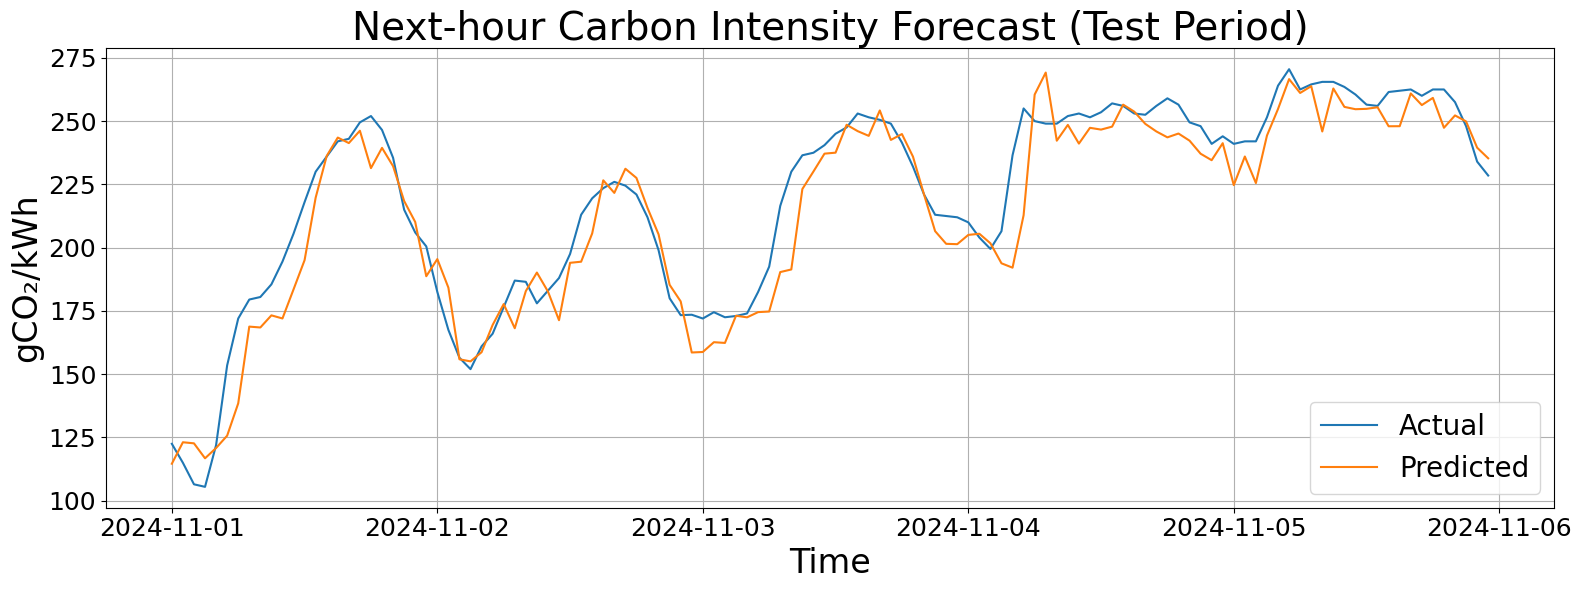

In [27]:
import matplotlib.pyplot as plt

hours = 24 * 5
t = test.index[:hours]

plt.figure(figsize=(16,6))
plt.plot(t, y_test[:hours], label="Actual")
plt.plot(t, y_pred[:hours], label="Predicted")

plt.title("Next-hour Carbon Intensity Forecast (Test Period)", fontsize=28)
plt.ylabel("gCO₂/kWh", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.legend(fontsize=20)
plt.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

# Save as vector (best for posters)
plt.savefig("fig_next_hour_forecast.svg", bbox_inches="tight", facecolor="white")
plt.savefig("fig_next_hour_forecast.pdf", bbox_inches="tight", facecolor="white")

# Save as high-res raster backup
plt.savefig("fig_next_hour_forecast.png", dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
